In [1]:

import itertools
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy
import pandas as pd
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial_normalised,
    jacobi_gauss_lobatto,
    jacobi_polynomial_normalised,
    jacobi_polynomial,
    grad_jacobi_polynomial,
    trigonometric_polynomial,
    trigonometric_polynomial_centered,
)
from utils import JacobiGL, constructD
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI

%load_ext autoreload
%autoreload 2

In [2]:
setup_plotting()

# b)
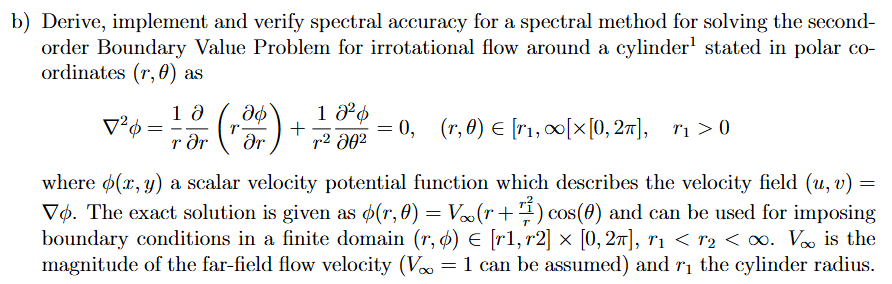

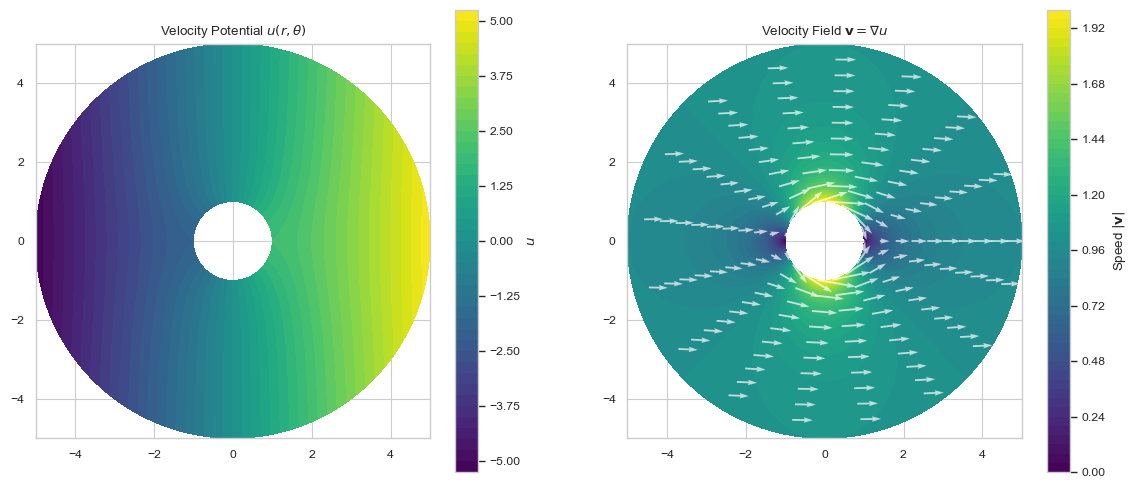

In [3]:
# Canonical Laplacian operator, so in cartesians it is simply pdv(ϕ, x, 2) + pdv(ϕ, y, 2) = 0
# Known parameters
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 5.0  # I came up with this one


def u_func_2_rtheta(r, theta):
    return V_inf * (r + r_1**2 / r) * np.cos(theta)


def u_func_2_xy(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return u_func_2_rtheta(r, theta)


def transform2xy(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def transform2rtheta(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


# Start by plotting the true solution
r_true = np.linspace(r_1, r_2, 500)
theta_true = np.linspace(0, 2 * np.pi, 500)
R_true, Theta_true = np.meshgrid(r_true, theta_true)
U_true = u_func_2_rtheta(R_true, Theta_true)

# Get velocities
V_r = np.gradient(U_true, r_true, axis=1)  # derivative along r direction
V_theta = (
    np.gradient(U_true, theta_true, axis=0) / R_true
)  # derivative along theta direction

# Convert to Cartesian grid for plotting
X_true = R_true * np.cos(Theta_true)
Y_true = R_true * np.sin(Theta_true)

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta_true) - V_theta * np.sin(Theta_true)
V_y = V_r * np.sin(Theta_true) + V_theta * np.cos(Theta_true)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
contour1 = ax1.contourf(X_true, Y_true, U_true, levels=50, cmap="viridis")
ax1.set_aspect("equal")
ax1.set_title("Velocity Potential $u(r,\\theta)$")
plt.colorbar(contour1, ax=ax1, label="$u$")

# Velocity magnitude with streamlines
speed = np.sqrt(V_x**2 + V_y**2)
contour2 = ax2.contourf(X_true, Y_true, speed, levels=50, cmap="viridis")
skip_x = 30
skip_y = 50
ax2.quiver(
    X_true[::skip_x, ::skip_y],
    Y_true[::skip_x, ::skip_y],
    V_x[::skip_x, ::skip_y],
    V_y[::skip_x, ::skip_y],
    color="white",
    alpha=0.7,
    scale=20,
)
ax2.set_aspect("equal")
ax2.set_title("Velocity Field $\\mathbf{v} = \\nabla u$")
plt.colorbar(contour2, ax=ax2, label="Speed $|\\mathbf{v}|$")

Text(-0.1, 0.5, 'Exact Solution')

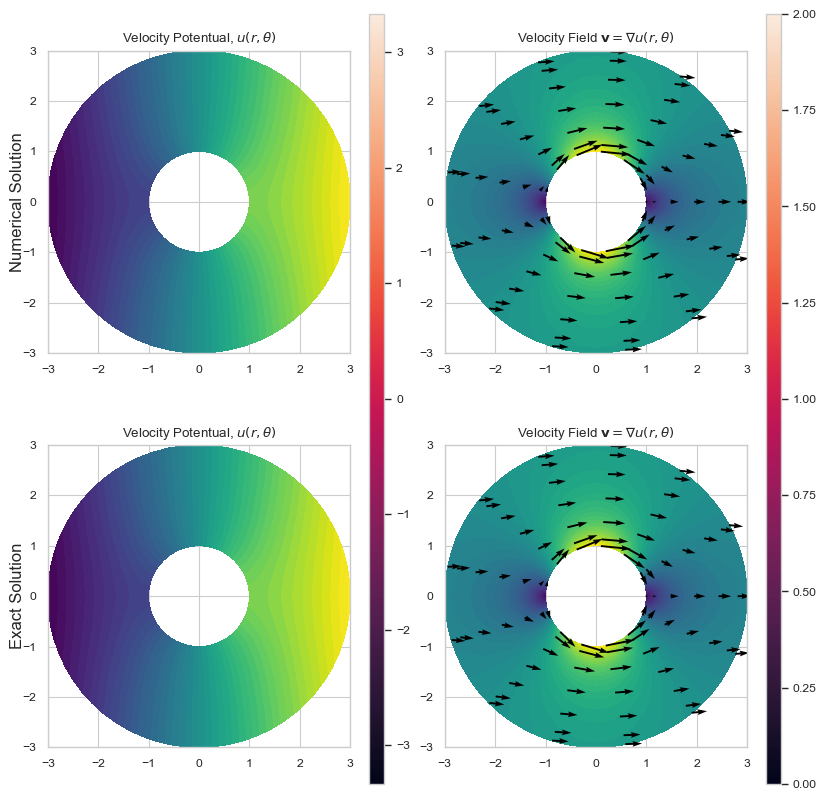

In [4]:
# We must need to do a really strange mapping since z=-1 -> r_1, z=1 -> r_2

# Discretisation parameters
N_r_grid = 32  # Nodes in r direction
N_theta_grid = 64  # Nodes in theta direction
N_r = N_r_grid - 1  # Polynomial degree in r direction
N_theta = N_theta_grid - 1  # Polynomial degree in theta direction

# Constants for the problem
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 3.0  # I came up with this one
L_theta = 2 * np.pi  # Domain length in theta direction

# Jacobi parameters for r direction
alpha_r = 0.0
beta_r = 0.0

# Get nodes for both dimensions
z_r, w_r = jacobi_gauss_lobatto(N_r, alpha_r, beta_r)
z_theta = np.linspace(0.0, 2 * np.pi, N_theta_grid, endpoint=False)  # Equidistant in theta

# Set up basis functions
basis_func_r = partial(jacobi_polynomial, alpha=alpha_r, beta=beta_r)
basis_func_r_grad = partial(grad_jacobi_polynomial, alpha=alpha_r, beta=beta_r)
basis_func_theta = partial(trigonometric_polynomial_centered, k=0, N=N_theta_grid, L=L_theta)
basis_func_theta_grad = partial(trigonometric_polynomial_centered, k=1, N=N_theta_grid, L=L_theta)

# Get differentiation matrix in r direction
V_r = construct_vandermonde(z_r, N_r + 1, basis_func_r)
V_r_z = construct_vandermonde(z_r, N_r + 1, basis_func_r_grad)
D_r_z = np.linalg.solve(
    V_r.T, V_r_z.T
).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

# Get differentiation matrix in theta direction
V_theta = construct_vandermonde(z_theta, N_theta_grid, basis_func_theta, dtype=np.complex128)
V_theta_z = construct_vandermonde(z_theta, N_theta_grid, basis_func_theta_grad, dtype=np.complex128)
D_theta_z = np.linalg.solve(
    V_theta.T, V_theta_z.T
).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

# Set up transformation from z_r to r
r_r = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2  # Map to [r_1, r_2]
J_zr = 2 / (r_2 - r_1)  # Jacobian of the transformation

R, Theta = np.meshgrid(r_r, z_theta, indexing="ij")
R_flat = R.flatten()
Theta_flat = Theta.flatten()

# Set up matrices for Laplacian
I_r = np.eye(N_r_grid)
I_theta = np.eye(N_theta_grid)
R_inv_diag = np.diag(1.0 / R_flat)
R_inv_sq_diag = np.diag(1.0 / R_flat**2)

# Create D using Kronecker products
D_z_full = np.kron(D_r_z, np.eye(N_theta_grid))
D_theta_full = np.kron(np.eye(N_r_grid), D_theta_z)

L_N = (
    (J_zr**2) * (D_z_full @ D_z_full)
    + R_inv_diag @ (J_zr * D_z_full)
    + R_inv_sq_diag @ (D_theta_full @ D_theta_full)
)

# Inner boundary
for j in range(N_theta_grid):
    idx = 0 * N_theta_grid + j  # First radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta_grid):
    idx = (N_r_grid - 1) * N_theta_grid + j  # Last radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# 12) Set up RHS
N_total = N_r_grid * N_theta_grid
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta_grid):
    # Inner
    F[0 * N_theta_grid + j] = u_func_2_rtheta(r_1, z_theta[j])

    # Outer
    F[(N_r_grid - 1) * N_theta_grid + j] = u_func_2_rtheta(r_2, z_theta[j])

# Solve
u_flat = np.linalg.solve(L_N, F)
u_flat = np.real(u_flat)  # Discard imaginary part, which is only due to numerical errors
u_numerical = u_flat.reshape((N_r_grid, N_theta_grid), order="C")

### Prepare for plot
u_exact = u_func_2_rtheta(R, Theta)

# This is for plotting to close the circle in theta
z_theta_plot = np.append(z_theta, 2 * np.pi)
u_numerical_plot = np.hstack([u_numerical, u_numerical[:, 0:1]])

R_plot, Theta_plot = np.meshgrid(r_r, z_theta_plot, indexing="ij")
u_exact_plot = u_func_2_rtheta(R_plot, Theta_plot)
X_plot = R_plot * np.cos(Theta_plot)
Y_plot = R_plot * np.sin(Theta_plot)


# Numerical - Potential
# Numerical - Field
V_r = J_zr * (D_r_z @ u_numerical)
V_theta = (1.0 / R) * (u_numerical @ D_theta_z.T)
V_theta = np.real(V_theta)  # Discard imaginary part

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta) - V_theta * np.sin(Theta)
V_y = V_r * np.sin(Theta) + V_theta * np.cos(Theta)

speed = np.sqrt(V_x**2 + V_y**2)

# Exact - Potential
# Exact - Field
V_r_exact = J_zr * (D_r_z @ u_exact)
V_theta_exact = (1.0 / R) * (u_exact @ D_theta_z.T)
V_theta_exact = np.real(V_theta_exact)  # Discard imaginary part

# Convert to Cartesian velocities
V_x_exact = V_r_exact * np.cos(Theta) - V_theta_exact * np.sin(Theta)
V_y_exact = V_r_exact * np.sin(Theta) + V_theta_exact * np.cos(Theta)

speed_exact = np.sqrt(V_x_exact**2 + V_y_exact**2)

# Plot
# Row 1: Numerical Solution
# Row 2: Exact Solution
# Column 1: Velocity Potential
# Column 2: Velocity Field

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cmap_potential = plt.get_cmap("viridis")
cmap_field = plt.get_cmap("viridis")
_potentials = [u_numerical, u_exact]
normalizer_potential = mpl.colors.Normalize(
    vmin=np.min(_potentials), vmax=np.max(_potentials)
)
_fields = [speed, speed_exact]
normalizer_field = mpl.colors.Normalize(vmin=np.min(_fields), vmax=np.max(_fields))

# Numerical - Potential
contour1 = axs[0, 0].contourf(
    X_plot,
    Y_plot,
    u_numerical_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[0, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[0, 0].set_aspect("equal")

# Numerical - Field
# For plotting, append first column to the end to close the circle
speed_plot = np.hstack([speed, speed[:, 0:1]])
V_x_plot = np.hstack([V_x, V_x[:, 0:1]])
V_y_plot = np.hstack([V_y, V_y[:, 0:1]])
contour2 = axs[0, 1].contourf(
    X_plot, Y_plot, speed_plot, levels=50, cmap=cmap_field, norm=normalizer_field
)
skip_x = 5
skip_y = 5
axs[0, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot[::skip_x, ::skip_y],
    V_y_plot[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[0, 1].set_aspect("equal")
axs[0, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r, \\theta)$")

# Exact - Potential
contour1 = axs[1, 0].contourf(
    X_plot,
    Y_plot,
    u_exact_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[1, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[1, 0].set_aspect("equal")

# Exact - Field
# For plotting, append first column to the end to close the circle
speed_plot_exact = np.hstack([speed_exact, speed_exact[:, 0:1]])
V_x_plot_exact = np.hstack([V_x_exact, V_x_exact[:, 0:1]])
V_y_plot_exact = np.hstack([V_y_exact, V_y_exact[:, 0:1]])
contour2 = axs[1, 1].contourf(
    X_plot, Y_plot, speed_plot_exact, levels=50, cmap=cmap_field, norm=normalizer_field
)
axs[1, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot_exact[::skip_x, ::skip_y],
    V_y_plot_exact[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[1, 1].set_aspect("equal")
axs[1, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r,\\theta)$")

fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Colorbars
im_potential = mpl.cm.ScalarMappable(norm=normalizer_potential)
cbar_potential = fig.colorbar(im_potential, ax=[axs[0, 0], axs[1, 0]], aspect=50)
im_field = mpl.cm.ScalarMappable(norm=normalizer_field)
cbar_field = fig.colorbar(im_field, ax=[axs[0, 1], axs[1, 1]], aspect=50)
# Vertical titles
axs[0, 0].text(
    -0.1,
    0.5,
    "Numerical Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, 0].transAxes,
    size=12,
)
axs[1, 0].text(
    -0.1,
    0.5,
    "Exact Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, 0].transAxes,
    size=12,
)


Text(-0.1, 0.5, 'Exact Solution')

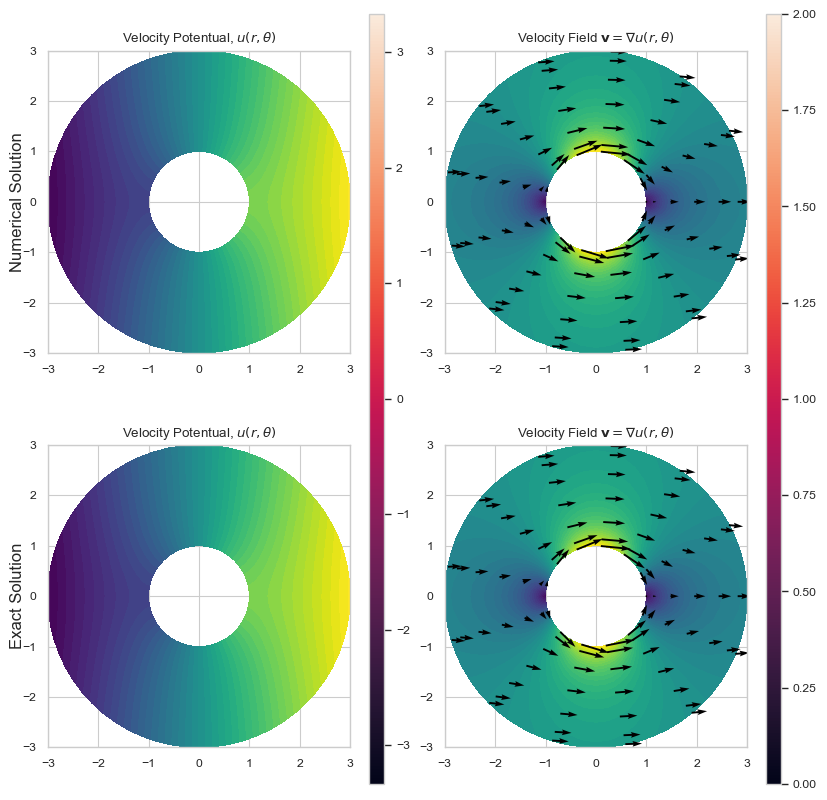

In [5]:
# OLD VERSION, pre switching to fourier basis functions
# We must need to do a really strange mapping since z=-1 -> r_1, z=1 -> r_2

# Discretisation parameters
N_r = 32  # Nodes in r direction
N_theta = 64  # Nodes in theta direction
P_r = N_r - 1  # Polynomial degree in r direction
P_theta = N_theta - 1  # Polynomial degree in theta direction

# Constants for the problem
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 3.0  # I came up with this one

# Jacobi parameters for r direction
alpha_r = 0.0
beta_r = 0.0

# Get nodes for both dimensions
z_r = JacobiGL(alpha_r, beta_r, P_r)  # GL for Legendre
z_theta = np.linspace(0.0, 2 * np.pi, N_theta, endpoint=False)  # Equidistant in theta

# Get differentiation matrix in r direction
D_z = constructD(z_r, alpha_r, beta_r)

# Get differentiation matrix in theta direction
D_theta = np.zeros((N_theta, N_theta))

for i in range(N_theta):
    for j in range(N_theta):
        if i != j:
            # Off-diagonal elements
            D_theta[i, j] = 0.5 * (-1) ** (i - j) / np.tan(np.pi * (i - j) / N_theta)
        # Diagonal elements are zero for periodic functions

# Set up transformation from z_r to r
r_r = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2  # Map to [r_1, r_2]
J_zr = 2 / (r_2 - r_1)  # Jacobian of the transformation

R, Theta = np.meshgrid(r_r, z_theta, indexing="ij")
R_flat = R.flatten()
Theta_flat = Theta.flatten()

# Set up matrices for Laplacian
I_r = np.eye(N_r)
I_theta = np.eye(N_theta)
R_inv_diag = np.diag(1.0 / R_flat)
R_inv_sq_diag = np.diag(1.0 / R_flat**2)

# Create D using Kronecker products
D_z_full = np.kron(D_z, np.eye(N_theta))
D_theta_full = np.kron(np.eye(N_r), D_theta)

L_N = (
    (J_zr**2) * (D_z_full @ D_z_full)
    + R_inv_diag @ (J_zr * D_z_full)
    + R_inv_sq_diag @ (D_theta_full @ D_theta_full)
)

# Inner boundary
for j in range(N_theta):
    idx = 0 * N_theta + j  # First radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta):
    idx = (N_r - 1) * N_theta + j  # Last radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# 12) Set up RHS
N_total = N_r * N_theta
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta):
    # Inner
    F[0 * N_theta + j] = u_func_2_rtheta(r_1, z_theta[j])

    # Outer
    F[(N_r - 1) * N_theta + j] = u_func_2_rtheta(r_2, z_theta[j])

# Solve
u_flat = np.linalg.solve(L_N, F)
u_numerical = u_flat.reshape((N_r, N_theta), order="C")

### Prepare for plot
u_exact = u_func_2_rtheta(R, Theta)

# This is for plotting to close the circle in theta
z_theta_plot = np.append(z_theta, 2 * np.pi)
u_numerical_plot = np.hstack([u_numerical, u_numerical[:, 0:1]])

R_plot, Theta_plot = np.meshgrid(r_r, z_theta_plot, indexing="ij")
u_exact_plot = u_func_2_rtheta(R_plot, Theta_plot)
X_plot = R_plot * np.cos(Theta_plot)
Y_plot = R_plot * np.sin(Theta_plot)


# Numerical - Potential
# Numerical - Field
V_r = J_zr * (D_z @ u_numerical)
V_theta = (1.0 / R) * (u_numerical @ D_theta.T)

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta) - V_theta * np.sin(Theta)
V_y = V_r * np.sin(Theta) + V_theta * np.cos(Theta)

speed = np.sqrt(V_x**2 + V_y**2)

# Exact - Potential
# Exact - Field
V_r_exact = J_zr * (D_z @ u_exact)
V_theta_exact = (1.0 / R) * (u_exact @ D_theta.T)

# Convert to Cartesian velocities
V_x_exact = V_r_exact * np.cos(Theta) - V_theta_exact * np.sin(Theta)
V_y_exact = V_r_exact * np.sin(Theta) + V_theta_exact * np.cos(Theta)

speed_exact = np.sqrt(V_x_exact**2 + V_y_exact**2)

# Plot
# Row 1: Numerical Solution
# Row 2: Exact Solution
# Column 1: Velocity Potential
# Column 2: Velocity Field

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cmap_potential = plt.get_cmap("viridis")
cmap_field = plt.get_cmap("viridis")
_potentials = [u_numerical, u_exact]
normalizer_potential = mpl.colors.Normalize(
    vmin=np.min(_potentials), vmax=np.max(_potentials)
)
_fields = [speed, speed_exact]
normalizer_field = mpl.colors.Normalize(vmin=np.min(_fields), vmax=np.max(_fields))

# Numerical - Potential
contour1 = axs[0, 0].contourf(
    X_plot,
    Y_plot,
    u_numerical_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[0, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[0, 0].set_aspect("equal")

# Numerical - Field
# For plotting, append first column to the end to close the circle
speed_plot = np.hstack([speed, speed[:, 0:1]])
V_x_plot = np.hstack([V_x, V_x[:, 0:1]])
V_y_plot = np.hstack([V_y, V_y[:, 0:1]])
contour2 = axs[0, 1].contourf(
    X_plot, Y_plot, speed_plot, levels=50, cmap=cmap_field, norm=normalizer_field
)
skip_x = 5
skip_y = 5
axs[0, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot[::skip_x, ::skip_y],
    V_y_plot[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[0, 1].set_aspect("equal")
axs[0, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r, \\theta)$")

# Exact - Potential
contour1 = axs[1, 0].contourf(
    X_plot,
    Y_plot,
    u_exact_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[1, 0].set_title("Velocity Potentual, $u(r,\\theta)$")
axs[1, 0].set_aspect("equal")

# Exact - Field
# For plotting, append first column to the end to close the circle
speed_plot_exact = np.hstack([speed_exact, speed_exact[:, 0:1]])
V_x_plot_exact = np.hstack([V_x_exact, V_x_exact[:, 0:1]])
V_y_plot_exact = np.hstack([V_y_exact, V_y_exact[:, 0:1]])
contour2 = axs[1, 1].contourf(
    X_plot, Y_plot, speed_plot_exact, levels=50, cmap=cmap_field, norm=normalizer_field
)
axs[1, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot_exact[::skip_x, ::skip_y],
    V_y_plot_exact[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[1, 1].set_aspect("equal")
axs[1, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r,\\theta)$")

fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Colorbars
im_potential = mpl.cm.ScalarMappable(norm=normalizer_potential)
cbar_potential = fig.colorbar(im_potential, ax=[axs[0, 0], axs[1, 0]], aspect=50)
im_field = mpl.cm.ScalarMappable(norm=normalizer_field)
cbar_field = fig.colorbar(im_field, ax=[axs[0, 1], axs[1, 1]], aspect=50)
# Vertical titles
axs[0, 0].text(
    -0.1,
    0.5,
    "Numerical Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, 0].transAxes,
    size=12,
)
axs[1, 0].text(
    -0.1,
    0.5,
    "Exact Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, 0].transAxes,
    size=12,
)
